<div class='alert alert-success'>
    <h1 align="center">Chapter 6: Neural Networks</h1> 
    <h3 align="center">Machine Learning Course (Fall 2018)</h3>
    <h5 align="center">Seyed Naser RAZAVI <a href='http://www.snrazavi.ir/ml-2018/'>ML2018</a></h5>
</div>

## Introduction

- Multi-class logistic regression
- Softmax classifier
- Non-linear classification
- Neural Networks
 - Training NNs: Backpropagation
 - Training NNs using advanced optimization methods
 - Implementing NNs using scikit-learn

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import warnings
import gzip, pickle
import numpy as np
import matplotlib.pyplot as plt

from utils import *
from plot_utils import *

warnings.filterwarnings(action='ignore')

In [2]:
# matplotlib configuration
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['image.interpolation'] = 'spline16'

# numpy setup
np.set_printoptions(precision=2)
np.random.seed(0)

## Load MNIST Dataset

**MNIST:** a dataset of handwritten digits, each digit is an image of size 28-by-28 pixels.

<img src='imgs/mnist_didigit_sample_three.png' width='50%'>

- 50000 training data
- 10000 validation data
- 10000 test data

In [3]:
DATA_PATH = 'data/mnist.pkl.gz'

with gzip.open(DATA_PATH, 'rb') as f:
    (X_train, y_train), (X_valid, y_valid), (X_test,  y_test) = pickle.load(f, encoding='latin1')

# As a sanity check, we print out the size of the data.
print('Training data shape:    ', X_train.shape)
print('Training labels shape:  ', y_train.shape)
print('Validation data shape:  ', X_valid.shape)
print('Validation labels shape:', y_valid.shape)
print('Test data shape:        ', X_test.shape)
print('Test labels shape:      ', y_test.shape)

Training data shape:     (50000, 784)
Training labels shape:   (50000,)
Validation data shape:   (10000, 784)
Validation labels shape: (10000,)
Test data shape:         (10000, 784)
Test labels shape:       (10000,)


### Visualize data

In [4]:
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

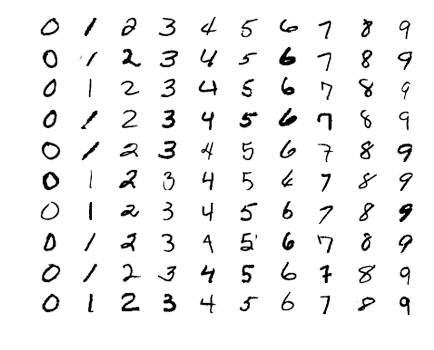

In [5]:
plot_random_samples(X_train, y_train, classes, samples_per_class=10)

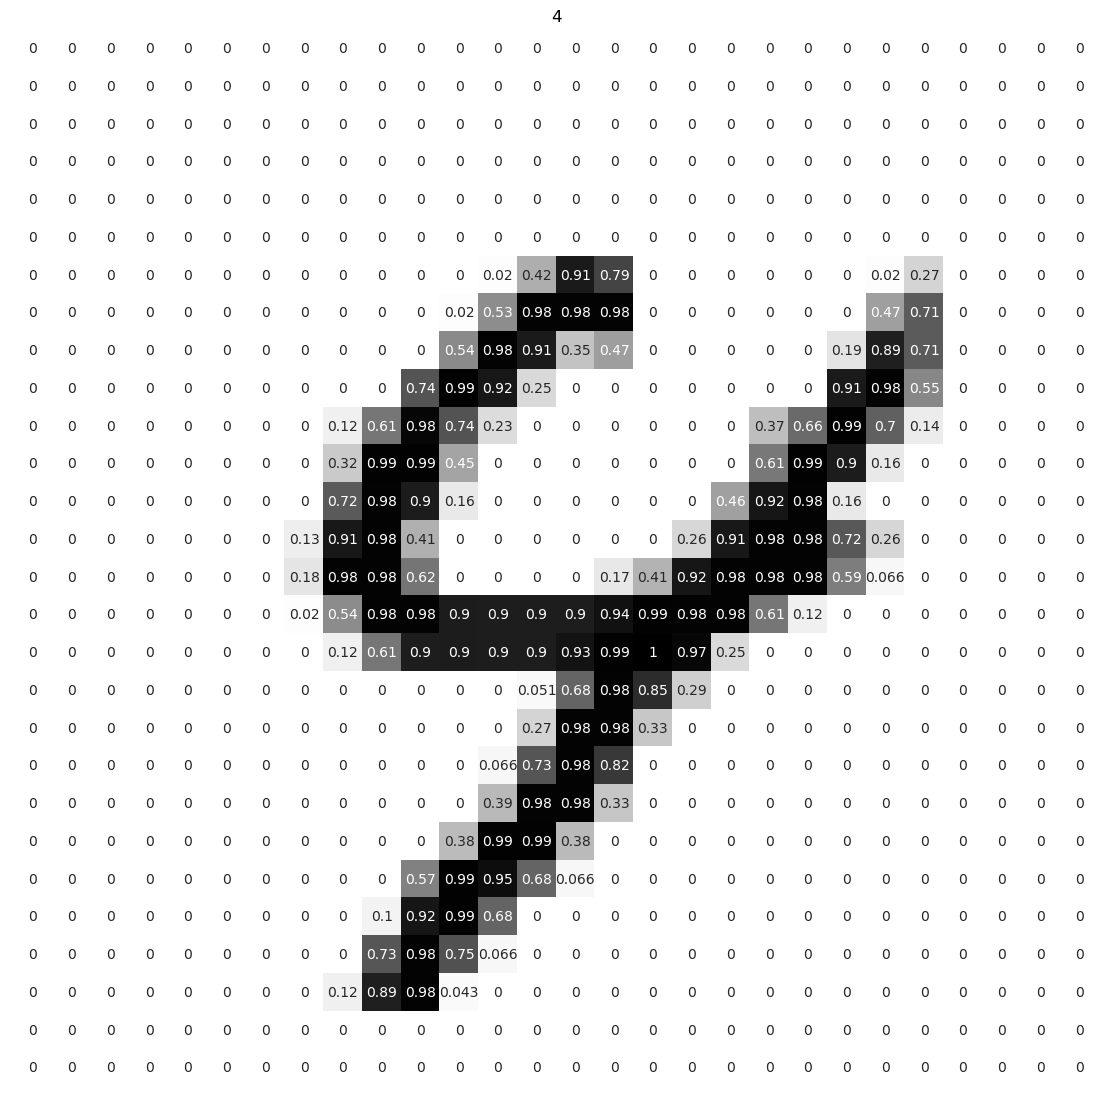

In [6]:
plot_sample(X_train, y_train, annot=True, idx=None)

### Preprocessing: normalization

- In this dataset, every pixel has a value in `[0, 1]`, so there is no need for feature scaling.
- But still we need to subtract the mean. 

Note that the mean vector is computed only from training data and subtracted from all data.

In [7]:
# compute mean vector from training data
mu = np.mean(X_train, axis=0)

# remove mean vector from all data
X_train -= mu
X_valid -= mu
X_test  -= mu

Plotting the mean vector

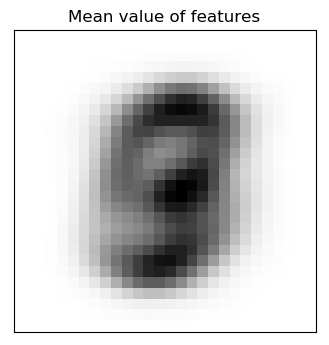

In [8]:
plt.figure(figsize=(4, 4))
plt.imshow(mu.reshape(28, 28), interpolation='nearest', cmap=plt.cm.Greys)
plt.xticks([])
plt.yticks([])
plt.title("Mean value of features")
plt.show()

## Multi-Class Logistic Regression

### Two-class logistic regression

$$h_\theta(x) = g(\theta_0 + \theta_1 x_1 + \theta_2 x_2 + \dots + \theta_n x_n) = g(\theta^T x + \theta_0) = \frac{1}{1 + e^{-(\theta^T x + \theta_0)}}$$

Notice that here, we have not included $x_0 = 1$ and hence treated the bias separetly.


Also, we can predict probabilties for a bunch of data simultanously using matrix operations:
$$h_\theta(X) = g(X \theta + \theta_0)$$
where $X$ is input matrix of shape $(m, n)$, so that each row of the matrix contains a single input vector.


### Multi-class logistic regression

- Suppose we have `m` input data each with `n` features from `c` different classes.
- In multi-class logistic regression, we train `c` classifiers, one classifier for each class.
- Therefor, we have `c` different $\theta$ vectors and `c` different biases ($\theta_0$).
- For efficiency, we can put all the $\theta$ vectors in one big $\Theta \in \mathbb{R}^{n \times c} $ matrix and all of the biases in one bias vector $\theta_0 \in \mathbb{R}^{c}$.

<img src='imgs/multi-class-lr-vectorized.png' width='75%'>

$$scores = X \Theta + \theta_0$$
where:
- $X \in \mathbb{R}^{m \times n}$
- $\Theta \in \mathbb{R}^{n \times c}$
- $\theta_0 \in \mathbb{R}^{1 \times c}$
- $scores \in \mathbb{R}^{m \times c}$

In python, we can compute the scores using the following statement:
```python
    scores = X @ Theta + theta0
```


#### Prediction

After computing scores, we have `c` predictions for each input data. By taking max over these predictions, we can easily compute the class label for each input data:
```python
    y_pred = np.argmax(scores, axis=1)
```

In [9]:
def predict(W, b, X):
    scores = X @ W + b
    return np.argmax(scores, axis=1)

#### Prediction for random parameters

Since here we have only 10 different classes, if we predict labels using random initial weights and biases, we must get an accuracy about 10 percent ($\frac{1}{10}$). This means that the classifier is guessing the labels totally random.

In [10]:
c = 10                # number of classes 
n = X_train.shape[1]  # number of features

# init parameters randomly
W = 0.01 * np.random.randn(n, c)
b = np.zeros(c)

# predict classes and compute accuracy
y_pred = predict(W, b, X_train)
acc = accuracy(y_pred, y_train)  # this function is defined in utils.py
print("Accuracy = {:.2f}%".format(acc))

Accuracy = 12.18%


## Softmax classifier

- In the multi-class logistic regression that we defined above (using sigmoid function), we are training `c` different classifiers. Therefore, the sum of the probabilities for different classes is not 1. 
- After computing the scores, we can use **Softmax** instead of sigmoid function, which transforms scores into a probability distribution. This way, instead of having `c` different classifiers which are acting separately, we have only one classifier which is able to distinguish among `c` different classes. 

<img src='imgs/softmax_classifier_for_digits.png' width='50%'>

$$probs = \text{softmax}(scores)$$

### Softmax function

Suppose we have a vector $s$ consisting the scores related to different classes for given input $x^{(i)}$ ($s \in \mathbb{R}^c$). Then $softmax(x^{(i)})$ computes a a vector of probabilities (one probability for each class). In fact, the $k$th element of this vector represents the probalitity of $x^{(i)}$ being a member of class $k$. This can be computed as following:

$$\text{softmax}(x^{(i)})_k = \frac{e^{s_k}}{\sum_{j=1}^{c} e^{s_j}}$$

in which, $y^{(i)}$ is the correct class for input $x^{(i)}$ and $s_j$ is the computed score for class $j$ for $j \in \{1, 2, \dots, c\}$.

## Training Softmax Classifier

**Training data:**
- $\{(x^{(i)}, y^{(i)})\}_{i=1}^{m}$,
- $x^{(i)} \in \mathbb{R}^{n}$,
- $y \in \{1, 2, \dots, c\}$
    

**Parameters:**
- weights: $W \in \mathbb{R}^{n \times c}$
- biases: $b \in \mathbb{R}^{c}$

**Loss function:** softmax loss function + regularization
$$L(W, b) = \frac{1}{m} \sum_{i=1}^{m} -\log(p_{y^{(i)}}) + \frac{\lambda}{2} \lVert W \rVert_{2}^{2}$$

As usual, we need to find the optimal $W$ and $b$ by minimizing $L(W, b)$. Again, we can use **gradient descent** algorithm or any other optimization method to minimize this loss function.

#### Gradient

$$\frac{\partial L_i}{\partial w^{(k)}} = \frac{\partial L_i}{\partial s_k} \frac{\partial s_k}{\partial w^{(k)}} = \frac{\partial L_i}{\partial s_k} x^{(i)}$$

for $k = y^{(i)}$:
$$\frac{\partial L_i}{\partial s_k} = p_k - 1$$

for $k \neq y^{(i)}$:
$$\frac{\partial L_i}{\partial s_k} = p_k$$

### Mini-Batch Gradient Descent

In [11]:
def softmax_loss(W, b, X_batch, y_batch, mode='train'):
    bs = X_batch.shape[0]  # batch size
    
    scores = X_batch @ W + b
    probs = softmax(scores)
    loss = -np.sum(np.log(probs[range(bs), y_batch])) / bs
    
    if mode == 'test':
        return loss
    
    # compute gradients w.r.t scores
    dscores = np.copy(probs)
    dscores[range(bs), y_batch] -= 1.0
    dscores /= bs
    
    # compute gradients w.r.t W and b
    db = dscores.sum(axis=0)
    dW = X_batch.T @ dscores
    
    return loss, dW, db

In [12]:
def mini_batch_gradient_descent(X_train, y_train, X_valid, y_valid, batch_size=32, 
                                alpha=0.01, lmbda=1e-4, num_epochs=100):
    
    m, n = X_train.shape
    num_batches = m % batch_size
    
    report = "Epoch {:3d}: training loss = {:.2f} | validation loss = {:.2f}"
    
    # init parameters randomly
    W = np.random.randn(n, 10) * 0.001
    b = np.zeros((10,))
    
    for epoch in range(num_epochs):
        train_loss = 0.
        
        for batch in range(num_batches):
            
            # select a random mini-batch
            idx = np.random.choice(m, batch_size, replace=False)
            X_batch, y_batch = X_train[idx], y_train[idx]
            
            # compute loss and gradient
            loss, dW, db = softmax_loss(W, b, X_batch, y_batch)  # data loss
            loss += 0.5 * lmbda * np.sum(W ** 2)                 # regularization loss
            dW += lmbda * W
            
            train_loss += loss
            
            # update parameters            
            b = b - alpha * db
            W = W - alpha * dW
        
        # report stats after each epoch
        train_loss /= num_batches        
        valid_loss = softmax_loss(W, b, X_valid, y_valid, mode='test')
        print(report.format(epoch+1, train_loss, valid_loss))
    
    return W, b

In [13]:
# hyper-parameters
alpha = 1e-2
lmbda = 1e-4
batch_size = 64
num_epochs = 100

# run mini-batch gradient descent
W, b = mini_batch_gradient_descent(X_train, y_train, X_valid, y_valid, 
                                   batch_size=batch_size, alpha=alpha,
                                   lmbda=lmbda, num_epochs=num_epochs)

Epoch   1: training loss = 2.22 | validation loss = 2.13
Epoch   2: training loss = 2.07 | validation loss = 1.98
Epoch   3: training loss = 1.93 | validation loss = 1.85
Epoch   4: training loss = 1.80 | validation loss = 1.73
Epoch   5: training loss = 1.69 | validation loss = 1.62
Epoch   6: training loss = 1.60 | validation loss = 1.53
Epoch   7: training loss = 1.52 | validation loss = 1.45
Epoch   8: training loss = 1.45 | validation loss = 1.38
Epoch   9: training loss = 1.37 | validation loss = 1.32
Epoch  10: training loss = 1.35 | validation loss = 1.27
Epoch  11: training loss = 1.25 | validation loss = 1.21
Epoch  12: training loss = 1.24 | validation loss = 1.17
Epoch  13: training loss = 1.18 | validation loss = 1.13
Epoch  14: training loss = 1.13 | validation loss = 1.09
Epoch  15: training loss = 1.12 | validation loss = 1.06
Epoch  16: training loss = 1.09 | validation loss = 1.03
Epoch  17: training loss = 1.06 | validation loss = 1.00
Epoch  18: training loss = 1.02

In [14]:
train_acc = accuracy(predict(W, b, X_train), y_train)
valid_acc = accuracy(predict(W, b, X_valid), y_valid)

print('Training accuracy =   {:.2f}%'.format(train_acc))
print('Validation accuracy = {:.2f}%'.format(valid_acc))

Training accuracy =   86.56%
Validation accuracy = 88.20%


#### Prediction for test data

In [15]:
test_acc = accuracy(predict(W, b, X_test), y_test)
print('Test accuracy =   {:.2f}%'.format(train_acc))

Test accuracy =   86.56%


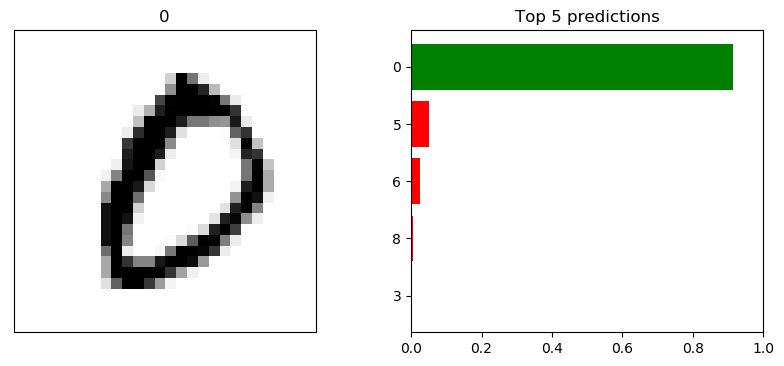

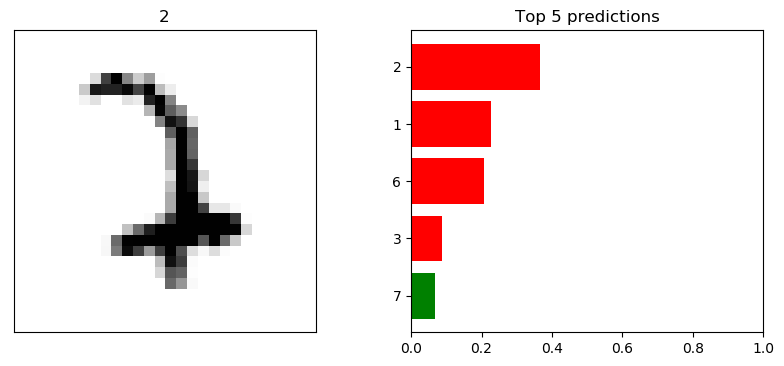

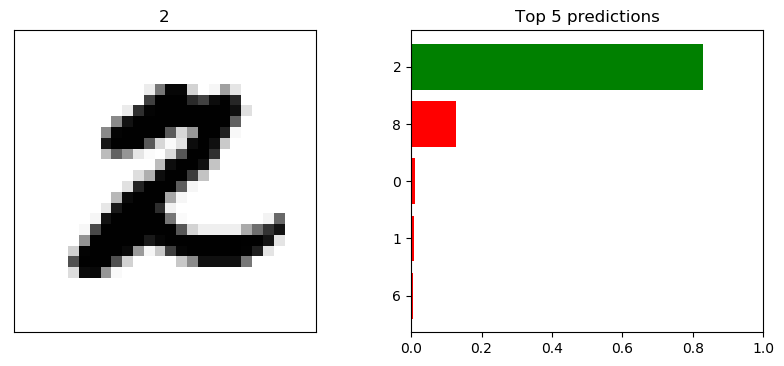

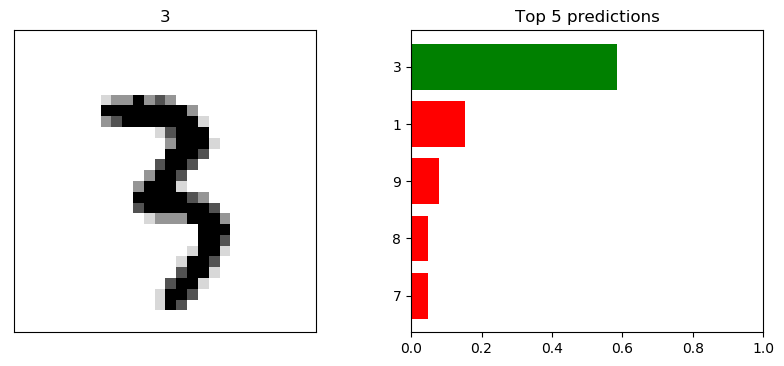

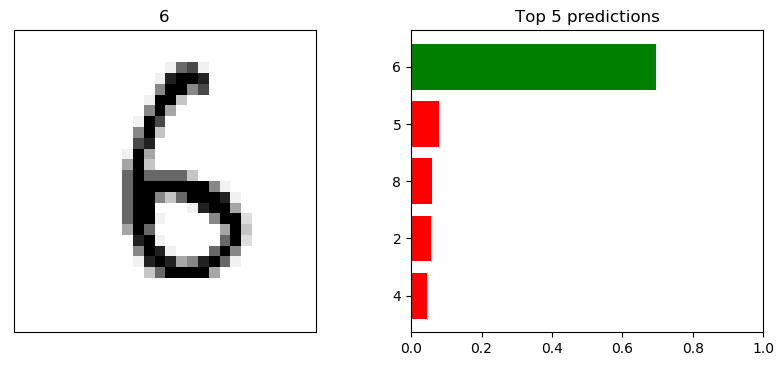

In [16]:
for _ in range(5):
    idx = np.random.choice(X_test.shape[0])
    probs = softmax(X_test[idx].reshape((1, -1)) @ W + b)[0]
    predict_and_plot(probs, X_test[idx], y_test[idx], mu, classes)

### Visualizing weights

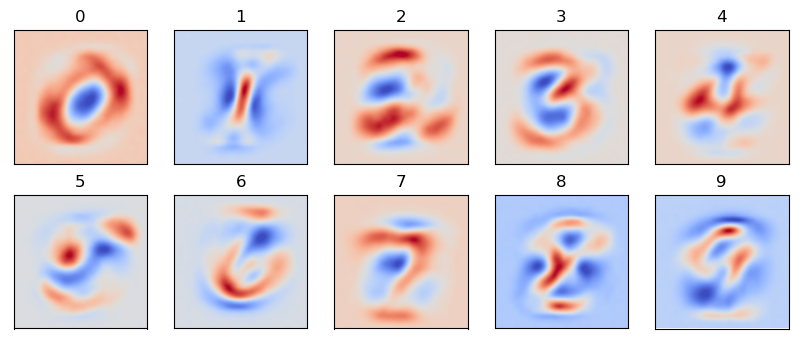

In [17]:
plt.figure(figsize=(10, 4))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(W[:, i].reshape((28, 28)), cmap=plt.cm.coolwarm)
    plt.xticks([])
    plt.yticks([])
    plt.title("%d" % i)
plt.show()

### Visualizing data in 2D space

**t-SNE:** ([paper](http://www.cs.toronto.edu/~hinton/absps/tsne.pdf))
- a technique for **dimensionality reduction**.
- particularly well suited for visualizing high-dimensional datasets in 2D or 3D.

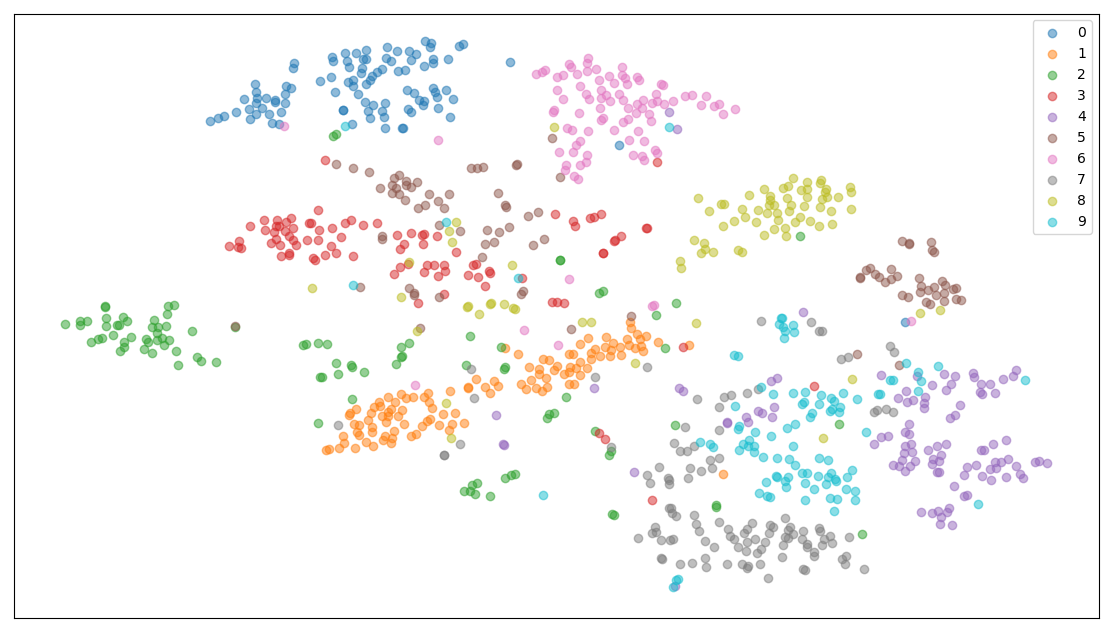

In [18]:
plot_tsne(X_train[:1000], y_train[:1000])

## Non-linear Classification: Neural Networks

<img src='imgs/neural_nets.png' width='90%'>

In [19]:
from utils import softmax_loss


class TwoLayerNeuralNetwork:
    
    def __init__(self, num_features=784, num_hiddens=20, num_classes=10):
        self.num_hiddens = num_hiddens
        self.num_classes = num_classes
        
        # random initialization: create random weights, set all biases to zero
        self.params = {}
        self.params['W1'] = np.random.randn(num_features, num_hiddens) * 0.001
        self.params['W2'] = np.random.randn(num_hiddens,  num_classes) * 0.001
        self.params['b1'] = np.zeros((num_hiddens,))
        self.params['b2'] = np.zeros((num_classes,))
        
    def forward(self, X):
        # forward step
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        
        # forward step
        h_in = X @ W1 + b1       # hidden layer input
        h = np.maximum(0, h_in)  # hidden layer output (using ReLU)
        scores = h @ W2 + b2     # neural net output
        
        return scores
                            
    def train_step(self, X, y):
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        
        # forward step
        h_in = X @ W1 + b1       # hidden layer input
        h = np.maximum(0, h_in)  # hidden layer output (using ReLU)
        scores = h @ W2 + b2     # neural net output
        
        # compute loss
        loss, dscores = softmax_loss(scores, y)
        
        # backward step
        db2 = dscores.sum(axis=0)
        dW2 = h.T @ dscores
        
        dh = dscores @ W2.T
        dh[h_in < 0] = 0.0
        db1 = dh.sum(axis=0)
        dW1 = X.T @ dh
        
        gradient = {'W1': dW1, 'b1': db1, 'W2': dW2, 'b2': db2}
                
        return loss, gradient
        
    def train(self, X_train, y_train, X_valid, y_valid, batch_size=50, 
              alpha=0.001, lmbda=0.0001, num_epochs=10):
        
        m, n = X_train.shape        
        num_batches = m // batch_size
        
        report = "{:3d}: training loss = {:.2f} | validation loss = {:.2f}"
        
        losses = []
        for epoch in range(num_epochs):
            train_loss = 0.0
            
            for _ in range(num_batches):
                W1, b1 = self.params['W1'], self.params['b1']
                W2, b2 = self.params['W2'], self.params['b2']
                
                # select a random mini-batch
                batch_idx = np.random.choice(m, batch_size, replace=False)
                X_batch, y_batch = X_train[batch_idx], y_train[batch_idx]

                # train on mini-batch
                data_loss, gradient = self.train_step(X_batch, y_batch)
                reg_loss = 0.5 * (np.sum(W1 ** 2) + np.sum(W2 ** 2))
                train_loss += (data_loss + lmbda * reg_loss)
                losses.append(data_loss + lmbda * reg_loss)

                # regularization
                gradient['W1'] += lmbda * W1
                gradient['W2'] += lmbda * W2

                # update parameters
                for p in self.params:
                    self.params[p] = self.params[p] - alpha * gradient[p]
            
            # report training loss and validation loss
            train_loss /= num_batches
            valid_loss = softmax_loss(self.forward(X_valid), y_valid, mode='test')
            print(report.format(epoch + 1, train_loss, valid_loss))
        
        return losses
    
    def predict(self, X):
        """ Predict labels for input data.
        """
        scores = self.forward(X)
        return np.argmax(scores, axis=1)
    
    def predict_proba(self, X):
        """ Predict probabilties of classes for each input data.
        """
        scores = self.forward(X)
        return softmax(scores)

In [20]:
mlp = TwoLayerNeuralNetwork(num_hiddens=20)
losses = mlp.train(X_train, y_train, X_valid, y_valid, 
                   alpha=0.05, lmbda=0.001, num_epochs=10)

  1: training loss = 1.30 | validation loss = 0.42
  2: training loss = 0.38 | validation loss = 0.28
  3: training loss = 0.32 | validation loss = 0.24
  4: training loss = 0.28 | validation loss = 0.22
  5: training loss = 0.26 | validation loss = 0.21
  6: training loss = 0.26 | validation loss = 0.20
  7: training loss = 0.24 | validation loss = 0.19
  8: training loss = 0.24 | validation loss = 0.18
  9: training loss = 0.23 | validation loss = 0.17
 10: training loss = 0.23 | validation loss = 0.16


In [21]:
train_acc = accuracy(mlp.predict(X_train), y_train)
print("Training accuracy   = {:.2f}%".format(train_acc))

test_acc = accuracy(mlp.predict(X_test), y_test)
print("Validation accuracy = {:.2f}%".format(test_acc))

Training accuracy   = 95.34%
Validation accuracy = 94.96%


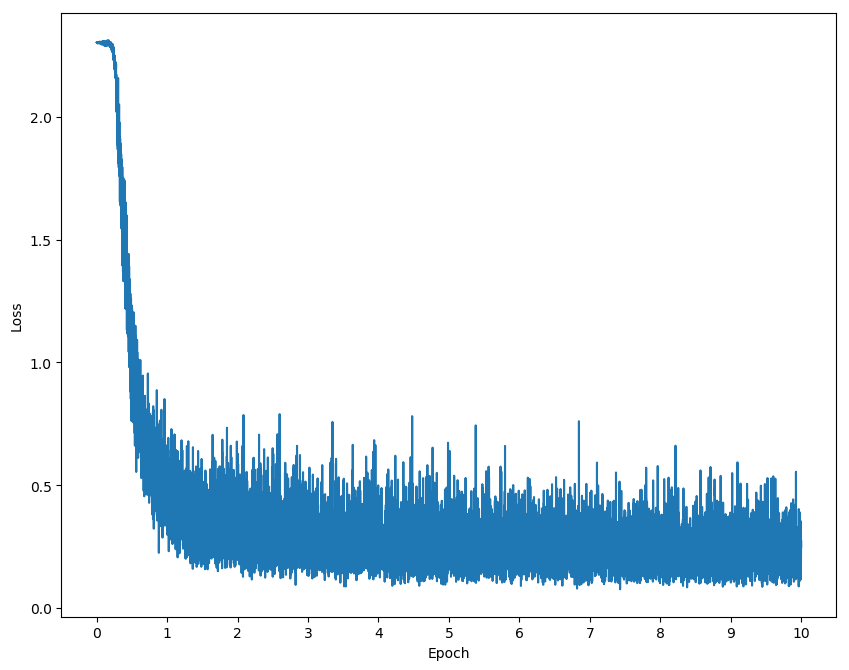

In [22]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(0, 10001, 1000), range(0, 11))
plt.show()

### Prediction for test data

In [23]:
test_acc = accuracy(predict(W, b, X_test), y_test)
print('Test accuracy = {:.2f}%'.format(train_acc))

Test accuracy = 95.34%


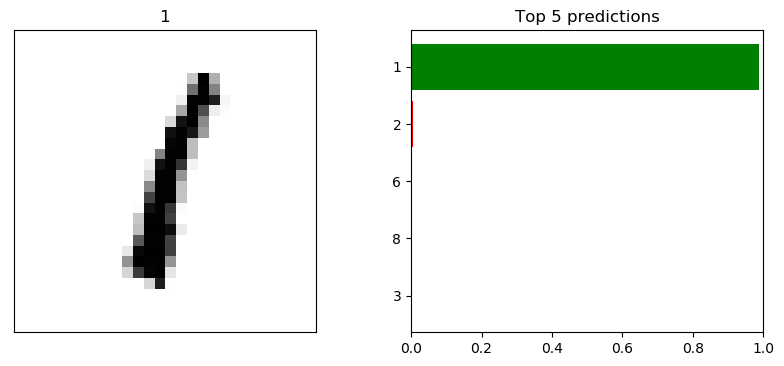

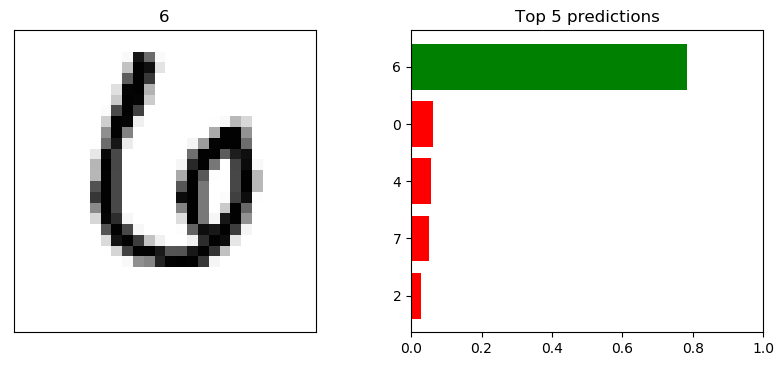

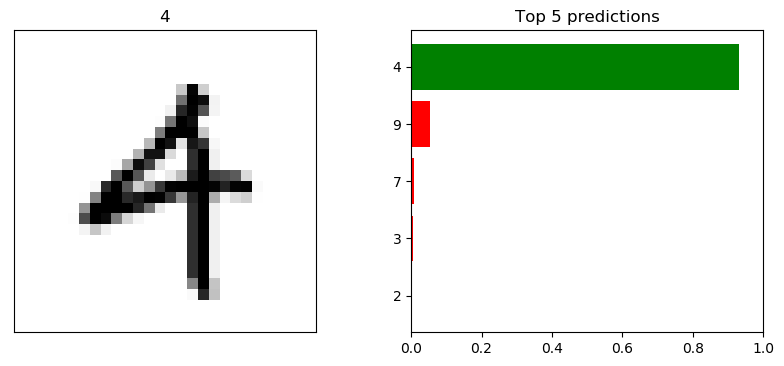

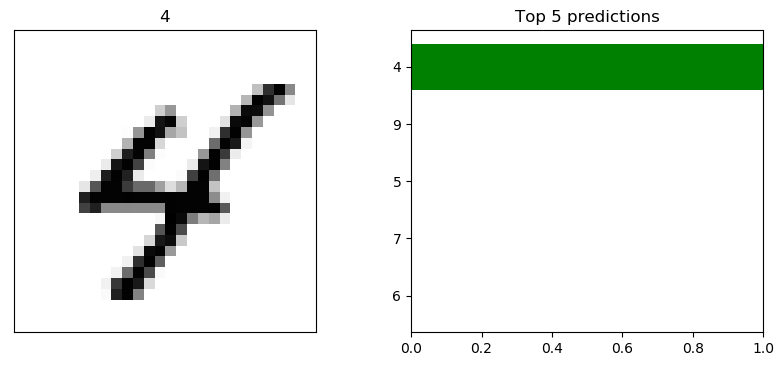

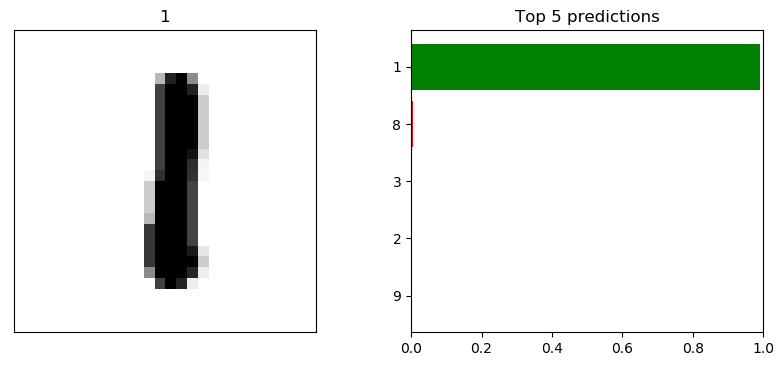

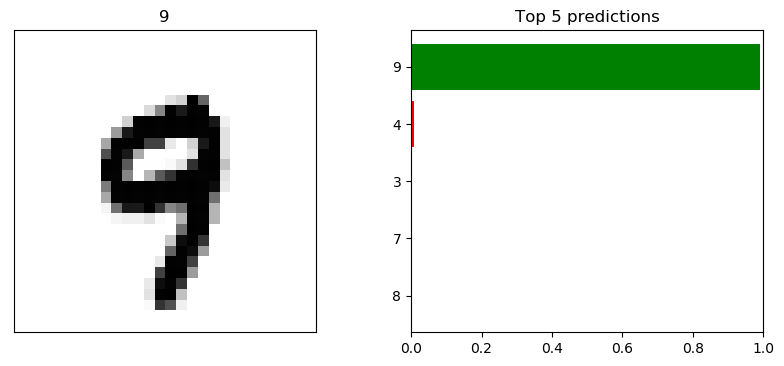

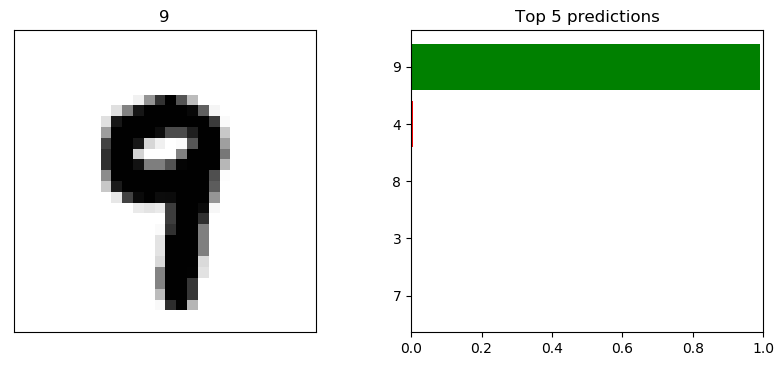

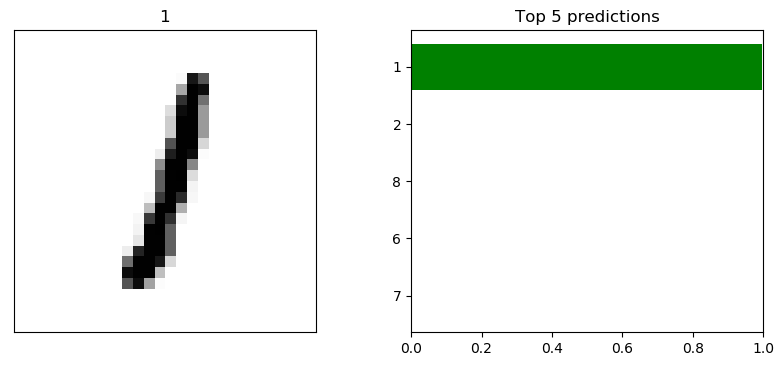

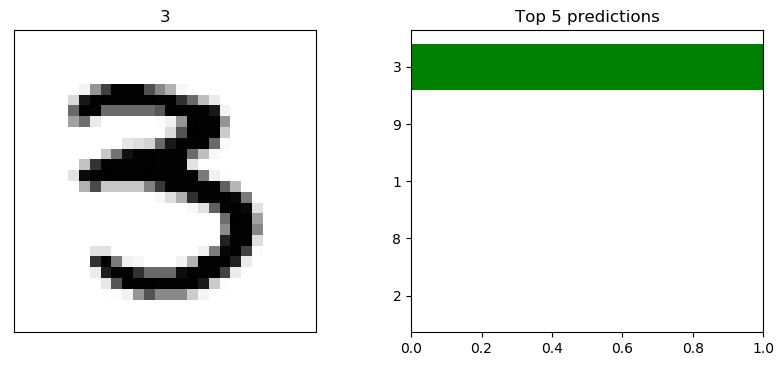

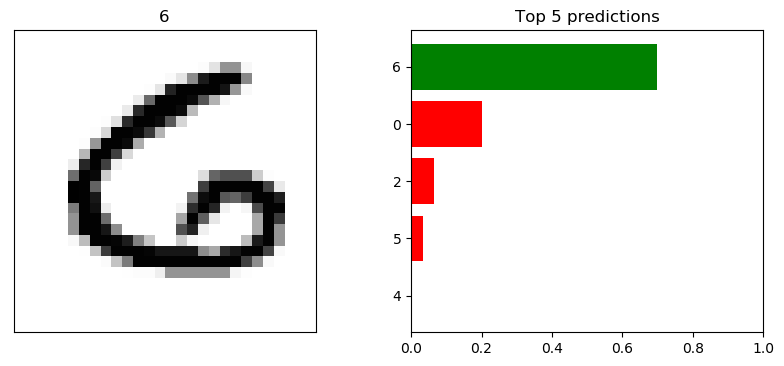

In [24]:
for i in range(10):
    idx = np.random.choice(len(y_test))
    probs = mlp.predict_proba(X_test[idx].reshape((1, -1)))[0]
    predict_and_plot(probs, X_test[idx], y_test[idx], mu, classes)

### Plot misclassified data

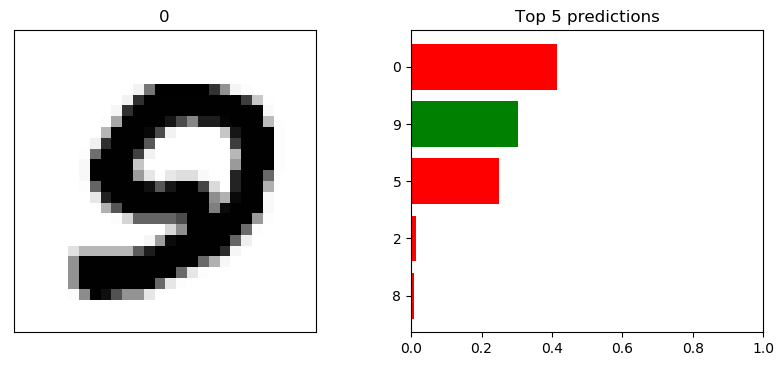

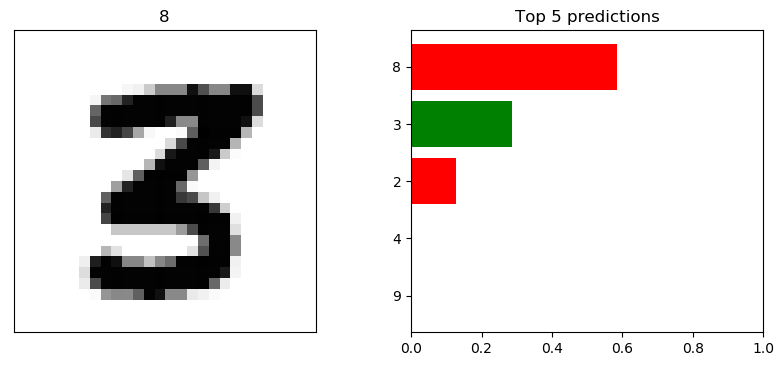

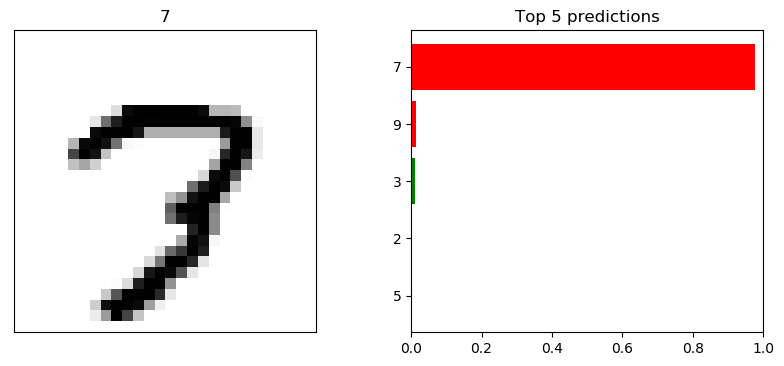

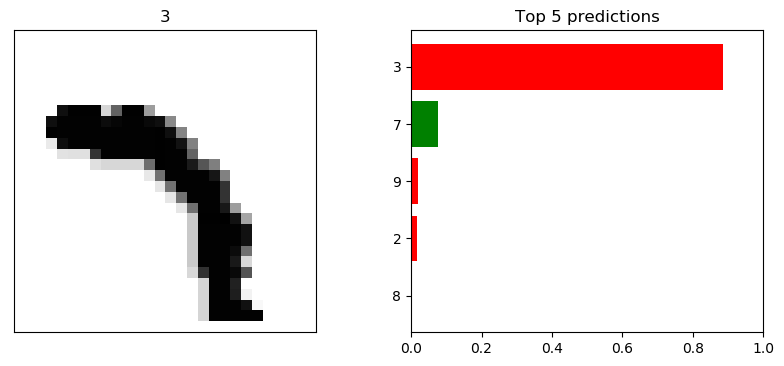

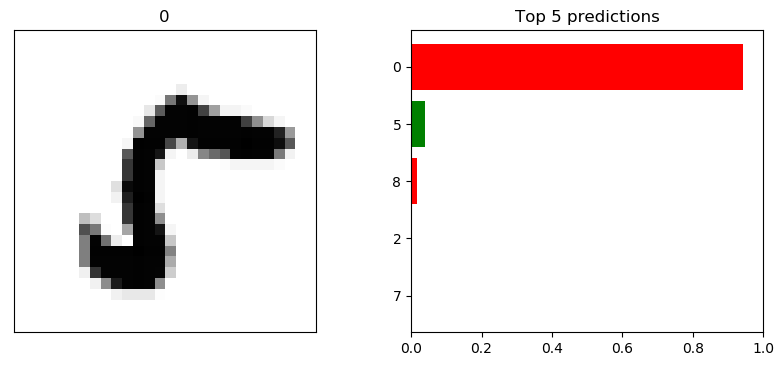

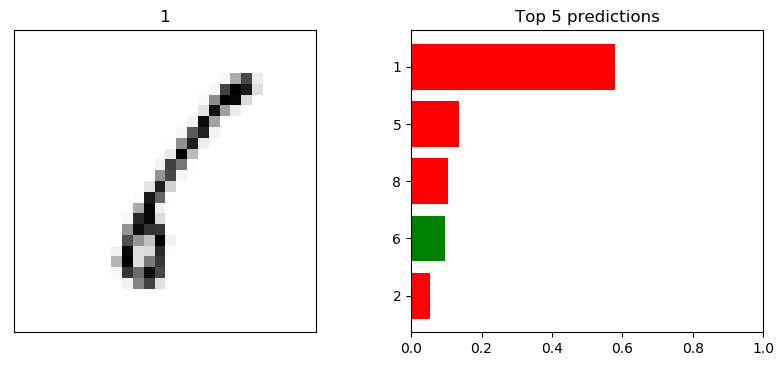

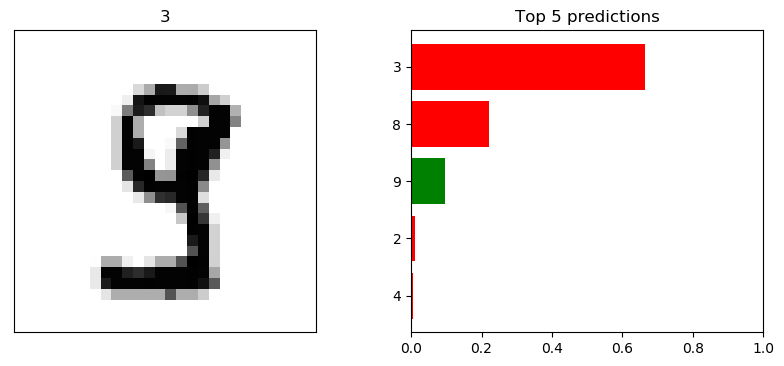

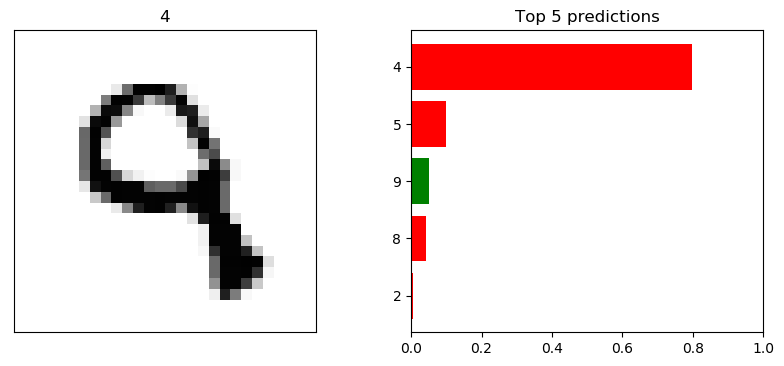

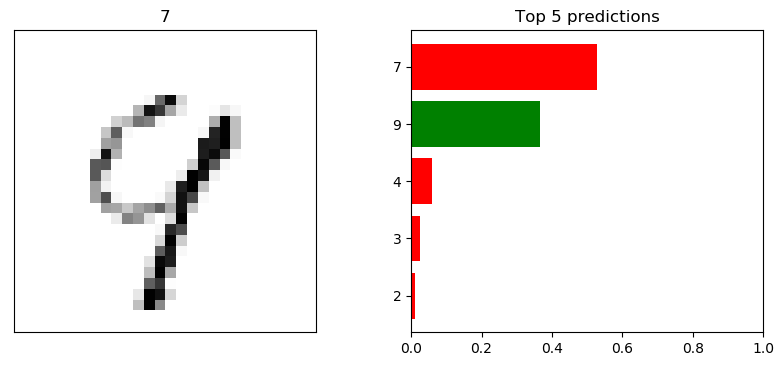

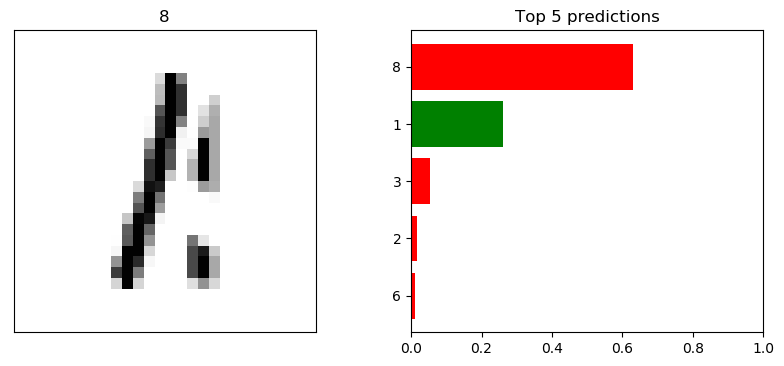

In [25]:
count = 10
y_pred = mlp.predict(X_test)
idx = np.flatnonzero(y_pred != y_test)
sample_idx = np.random.choice(idx, count)

for i in sample_idx:
    probs = mlp.predict_proba(X_test[i].reshape((1, -1)))[0]
    predict_and_plot(probs, X_test[i], y_test[i], mu, classes)

### Confusion matrix

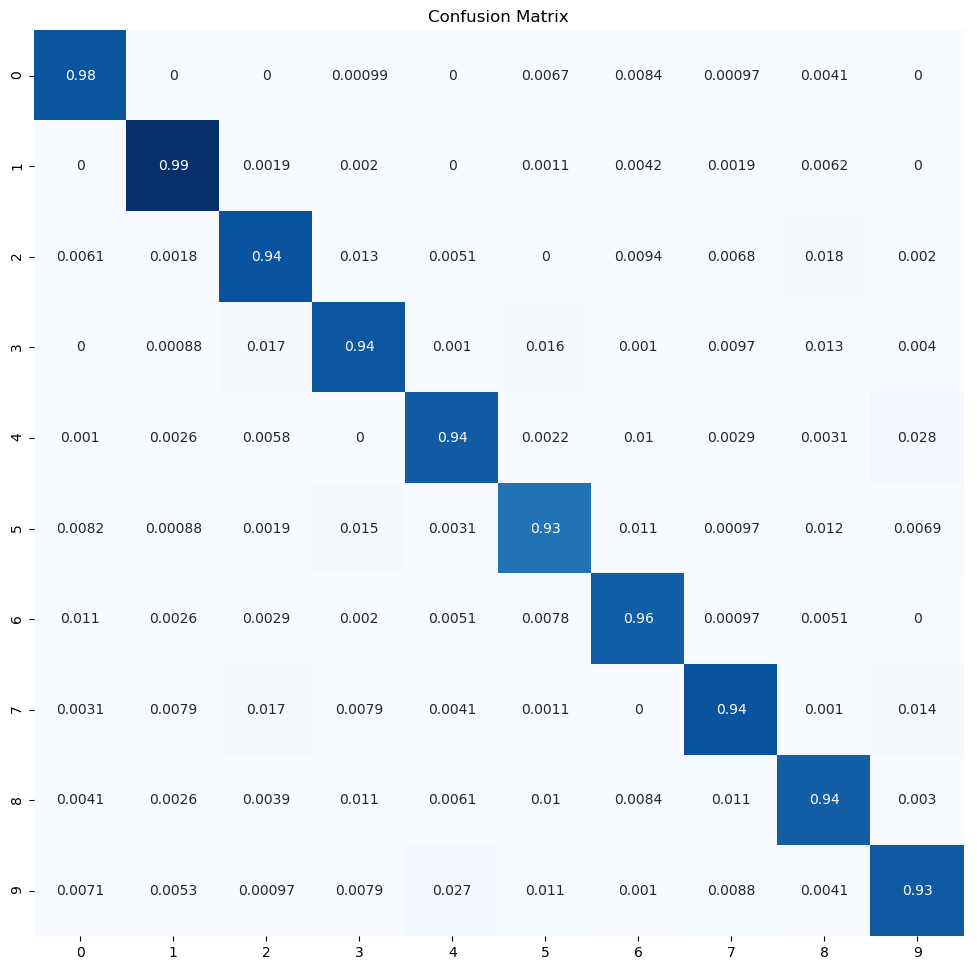

In [26]:
y_pred = mlp.predict(X_test)
plot_confusion_matrix(y_test, y_pred, normalize=True)

### Visualizing features

In [27]:
W = mlp.params['W1']
print(W.shape)

(784, 20)


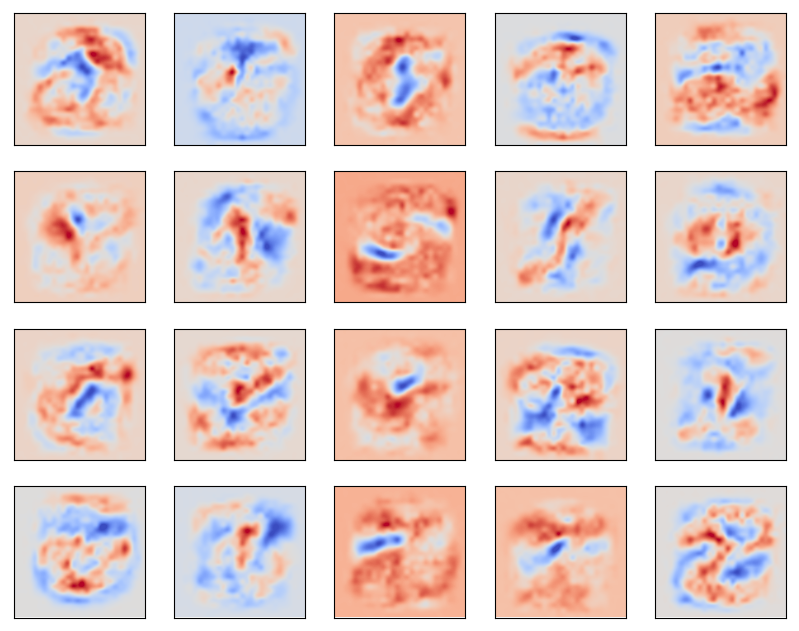

In [28]:
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(W[:, i].reshape((28, 28)), cmap=plt.cm.coolwarm)
    plt.xticks([])
    plt.yticks([])
plt.show()

## Training Using Advanced Optimization Methods

In [29]:
from scipy.optimize import minimize

In [30]:
def neural_net_loss(W, X, y, lmbda=0.001, F=784, H=20, C=10, mode='train'):
    
    # extract W1, b1, W2, b2 from W
    W1 = np.reshape(W[: F * H], (F, H))
    b1 = W[F * H: (F + 1) * H]
    
    W2 = np.reshape(W[(F + 1) * H: (F + 1) * H + H * C], (H, C))
    b2 = W[(F + 1) * H + H * C:]
    
    # Forward step
    h_in = X @ W1 + b1
    h = np.maximum(0, h_in)
    scores = h @ W2 + b2
        
    # compute loss
    if mode != 'train':
        return softmax_loss(scores, y, mode=mode)
    
    loss, dscores = softmax_loss(scores, y)
    loss += 0.5 * lmbda * (np.sum(W1 ** 2) + np.sum(W2 ** 2))
    
    # Backward Step
    db2 = dscores.sum(axis=0)
    dW2 = h.T @ dscores
    dh = dscores @ W2.T
    
    dh[h_in < 0] = 0.0
    db1 = dh.sum(axis=0)
    dW1 = X.T @ dh
    
    dW1 += lmbda * W1
    dW2 += lmbda * W2
    
    # concatenate all grads in a column vector
    dW = np.concatenate((dW1.ravel(), db1, dW2.ravel(), db2), axis=0)
    
    return loss, dW

In [31]:
def report_callback(W):
    loss = neural_net_loss(W, X_valid, y_valid, mode='test')
    print("Validation accuracy = {:.2f}".format(loss))

In [32]:
def predict_nn(W1, b1, W2, b2, X):
    h = np.maximum(0, X @ W1 + b1)
    scores = h @ W2 + b2
    return np.argmax(scores, axis=1)

In [33]:
F = 784  # num. features
H = 20   # num. hidden neurons
C = 10   # num. classes

# create and init parameters W1, W2
W1 = np.random.randn(F, H) * 0.001
W2 = np.random.randn(H, C) * 0.001

b1 = np.zeros((H,))
b2 = np.zeros((C,))

# concat all parameters in one column vector
W = np.concatenate((W1.ravel(), b1, W2.ravel(), b2), axis=0)

In [34]:
result = minimize(
    neural_net_loss, 
    x0=W, 
    args=(X_train, y_train), 
    method='CG', 
    jac=True,
    options={'maxiter': 50},
    callback=report_callback
)

Validation accuracy = 2.30
Validation accuracy = 1.78
Validation accuracy = 1.78
Validation accuracy = 1.39
Validation accuracy = 1.07
Validation accuracy = 0.85
Validation accuracy = 0.71
Validation accuracy = 0.60
Validation accuracy = 0.52
Validation accuracy = 0.45
Validation accuracy = 0.37
Validation accuracy = 0.34
Validation accuracy = 0.32
Validation accuracy = 0.30
Validation accuracy = 0.28
Validation accuracy = 0.27
Validation accuracy = 0.26
Validation accuracy = 0.25
Validation accuracy = 0.24
Validation accuracy = 0.23
Validation accuracy = 0.23
Validation accuracy = 0.22
Validation accuracy = 0.21
Validation accuracy = 0.20
Validation accuracy = 0.19
Validation accuracy = 0.19
Validation accuracy = 0.18
Validation accuracy = 0.18
Validation accuracy = 0.18
Validation accuracy = 0.17
Validation accuracy = 0.17
Validation accuracy = 0.17
Validation accuracy = 0.16
Validation accuracy = 0.16
Validation accuracy = 0.16
Validation accuracy = 0.16
Validation accuracy = 0.16
V

In [35]:
result

     fun: 0.2048412634439665
     jac: array([ 1.65e-08, -4.13e-08, -5.61e-08, ..., -3.04e-04, -6.36e-04,
       -1.16e-05])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 118
     nit: 50
    njev: 110
  status: 1
 success: False
       x: array([ 1.65e-05, -4.13e-05, -5.61e-05, ..., -4.04e-01,  1.29e+00,
        1.96e-01])

In [36]:
W = result.x

# extract W1, b1, W2, b2 from W
W1 = np.reshape(W[: F * H], (F, H))
b1 = W[F * H: (F + 1) * H]

W2 = np.reshape(W[(F + 1) * H: (F + 1) * H + H * C], (H, C))
b2 = W[(F + 1) * H + H * C:]

In [37]:
acc = accuracy(predict_nn(W1, b1, W2, b2, X_test), y_test)
print("Test accuracy = {:.2f}".format(acc))

Test accuracy = 95.45


### Neural networks in scikit learn

In [38]:
from sklearn.neural_network import MLPClassifier

In [39]:
model = MLPClassifier(hidden_layer_sizes=(20,), learning_rate='adaptive', alpha=1.0, max_iter=50, verbose=1)
model.fit(X_train, y_train);

Iteration 1, loss = 0.94137689
Iteration 2, loss = 0.51294232
Iteration 3, loss = 0.46339161
Iteration 4, loss = 0.44027582
Iteration 5, loss = 0.42637227
Iteration 6, loss = 0.41688244
Iteration 7, loss = 0.41073931
Iteration 8, loss = 0.40546546
Iteration 9, loss = 0.40169460
Iteration 10, loss = 0.39830584
Iteration 11, loss = 0.39583788
Iteration 12, loss = 0.39359093
Iteration 13, loss = 0.39116584
Iteration 14, loss = 0.38972034
Iteration 15, loss = 0.38807640
Iteration 16, loss = 0.38711663
Iteration 17, loss = 0.38629843
Iteration 18, loss = 0.38569876
Iteration 19, loss = 0.38459624
Iteration 20, loss = 0.38384348
Iteration 21, loss = 0.38362372
Iteration 22, loss = 0.38261567
Iteration 23, loss = 0.38201126
Iteration 24, loss = 0.38167185
Iteration 25, loss = 0.38119695
Iteration 26, loss = 0.38068627
Iteration 27, loss = 0.38008595
Iteration 28, loss = 0.37972948
Iteration 29, loss = 0.37938777
Iteration 30, loss = 0.37906436
Iteration 31, loss = 0.37866008
Iteration 32, los

In [40]:
train_acc = model.score(X_train, y_train)
print("Train accuracy = {:.2f}%".format(train_acc * 100))

test_acc = model.score(X_test, y_test)
print("Test accuracy  = {:.2f}%".format(test_acc * 100))

Train accuracy = 95.20%
Test accuracy  = 95.00%
